In [1]:
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
# from keras.models import Model

In [2]:
test_path = 'Data/chest_xray/test/'
train_path = 'Data/chest_xray/train'
val_path = 'Data/chest_xray/val/'

In [3]:
#Ensuring that it using my gpu and loading data using my gpu
with tf.device('/GPU:0'):

    test_generator = ImageDataGenerator(
        rescale=1.0/255).flow_from_directory(test_path, target_size=(200, 200), batch_size=312)
    train_generator = ImageDataGenerator(
        rescale=1.0/255).flow_from_directory(train_path, target_size=(200, 200), batch_size=2608)
    val_generator = ImageDataGenerator(
        rescale=1.0/255).flow_from_directory(val_path, target_size=(200, 200), batch_size=16)
    
    #Grabbing data
    train_images, train_labels = next(train_generator)
    test_images, test_labels = next(test_generator)
    val_images, val_labels = next(val_generator)

     # Create placeholders for train images
    train_images = tf.Variable(initial_value=train_images, shape=train_images.shape, trainable=False, dtype=tf.float32)
    test_images = tf.Variable(initial_value=test_images, shape=test_images.shape, trainable=False, dtype=tf.float32)
    val_images = tf.Variable(initial_value=val_images, shape=val_images.shape, trainable=False, dtype=tf.float32)

    
    #Creating labels
    train_labels = tf.Variable(train_labels.T[0], trainable=False, dtype=tf.float32)
    test_labels = tf.Variable(test_labels.T[0], trainable=False, dtype=tf.float32)
    val_labels = tf.Variable(val_labels.T[0], trainable=False, dtype=tf.float32)

    

Found 624 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [4]:
train_images.shape

TensorShape([2608, 200, 200, 3])

In [5]:
train_labels.shape

TensorShape([2608])

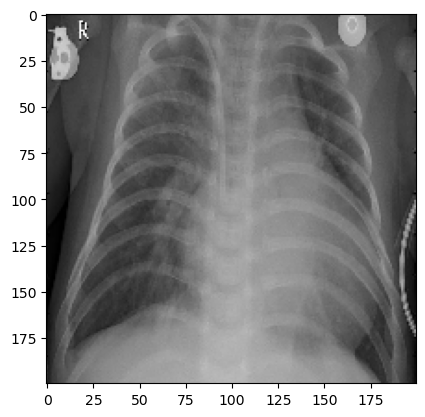

In [6]:
plt.imshow(train_images[3])

In [7]:
#try with only flat/dense
#FSM
model = models.Sequential()

model.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='sigmoid',
                        input_shape=(200, 200, 3)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.summary()


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 313632)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 313633    
Total params: 314,529
Trainable params: 314,529
Non-trainable params: 0
_________________________________________________________________


In [8]:
fsm=model.fit(train_images.numpy(), train_labels.numpy(), initial_epoch=0, epochs = 25, batch_size = 64)

Epoch 1/25
41/41 [==============================] - 4s 40ms/step - loss: 10.3728 - accuracy: 0.6338
Epoch 2/25
41/41 [==============================] - 1s 35ms/step - loss: 6.1104 - accuracy: 0.6300
Epoch 3/25
41/41 [==============================] - 1s 35ms/step - loss: 2.6794 - accuracy: 0.6806
Epoch 4/25
41/41 [==============================] - 1s 35ms/step - loss: 0.3715 - accuracy: 0.8873
Epoch 5/25
41/41 [==============================] - 1s 33ms/step - loss: 0.2313 - accuracy: 0.9183
Epoch 6/25
41/41 [==============================] - 1s 31ms/step - loss: 0.1787 - accuracy: 0.9264
Epoch 7/25
41/41 [==============================] - 1s 31ms/step - loss: 0.1653 - accuracy: 0.9375
Epoch 8/25
41/41 [==============================] - 1s 31ms/step - loss: 0.1528 - accuracy: 0.9387
Epoch 9/25
41/41 [==============================] - 1s 31ms/step - loss: 0.2190 - accuracy: 0.9156
Epoch 10/25
41/41 [==============================] - 1s 31ms/step - loss: 0.2825 - accuracy: 0.8976
Epoch 11

In [9]:
train_loss, train_acc = model.evaluate(train_images.numpy(), train_labels.numpy())
test_loss, test_acc = model.evaluate(test_images.numpy(), test_labels.numpy())

10/10 [==============================] - 0s 13ms/step - loss: 0.8472 - accuracy: 0.7756


<Axes: >

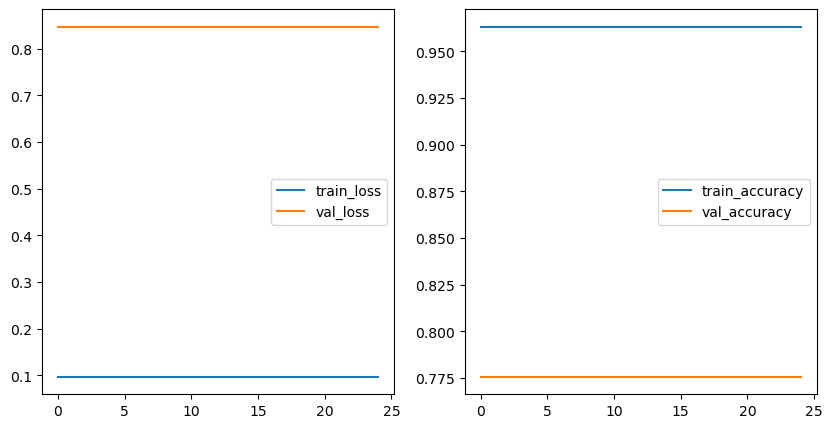

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=fsm.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=fsm.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=fsm.epoch, y=test_loss, ax=ax1, label='val_loss')
sns.lineplot(x=fsm.epoch, y=test_acc, ax=ax2, label='val_accuracy')


In [11]:
model2 = models.Sequential()

model2.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='sigmoid',
                        input_shape=(200, 200, 3)))

model2.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(layers.Conv2D(64, (3, 3), activation='sigmoid'))

model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

In [12]:
learning_rates = [0.1, 0.01, 0.05]

with tf.device('/GPU:0'):
    for lr in learning_rates:
        #Setting learning rate
        optimizer = optimizers.Adam(learning_rate=lr)

        #compilew new model
        model2.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
        #fitting model
        model2.fit(train_images.numpy(), train_labels.numpy(), epochs=25, batch_size=64,
                   verbose=0)

        #evaluate models
        train_loss, train_accuracy = model2.evaluate(train_images.numpy(), train_labels.numpy(), batch_size = 64)
        test_loss, test_accuracy = model2.evaluate(test_images.numpy(), test_labels.numpy(), batch_size = 64)

        #printing an update
        print(f"Learning Rate: {lr}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


5/5 [==============================] - 0s 39ms/step - loss: 4.7160 - accuracy: 0.6827
Learning Rate: 0.1, Train Loss: 0.36188700795173645, Train Accuracy: 0.9194785356521606, Test Loss: 4.716001510620117, Test Accuracy: 0.682692289352417
5/5 [==============================] - 0s 14ms/step - loss: 3.9849 - accuracy: 0.6987
Learning Rate: 0.01, Train Loss: 0.008041459135711193, Train Accuracy: 0.9976993799209595, Test Loss: 3.984868049621582, Test Accuracy: 0.6987179517745972
5/5 [==============================] - 0s 14ms/step - loss: 4.3224 - accuracy: 0.6827
Learning Rate: 0.05, Train Loss: 0.002382455160841346, Train Accuracy: 1.0, Test Loss: 4.322406768798828, Test Accuracy: 0.682692289352417


In [13]:
# adding a early stopping

early_stopping = EarlyStopping(monitor='loss',
                               min_delta=1e-4,
                               verbose=1,
                               patience=5,
                               mode='min')


In [14]:
model3 = models.Sequential()

model3.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='sigmoid',
                        input_shape=(200, 200, 3)))
model3.add(Dropout(.3))

model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='sigmoid'))
model3.add(Dropout(.3))

model3.add(MaxPooling2D(pool_size=(2, 2)))


model3.add(Flatten())
model3.add(Dense(12, activation='sigmoid'))
# model3.add(Dense(6, activation='sigmoid'))
model3.add(Dense(1, activation='sigmoid'))

model3.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
dropout (Dropout)            (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 97, 97, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 147456)           

In [16]:
optimizer = optimizers.Adam(learning_rate=.1)
model3.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

model3.fit(train_images.numpy(), train_labels.numpy(), epochs=25, batch_size=64, callbacks = [early_stopping])

Epoch 1/25
41/41 [==============================] - 4s 84ms/step - loss: 0.5939 - accuracy: 0.7266
Epoch 2/25
41/41 [==============================] - 3s 77ms/step - loss: 0.5739 - accuracy: 0.7435
Epoch 3/25
41/41 [==============================] - 3s 77ms/step - loss: 0.5707 - accuracy: 0.7435
Epoch 4/25
41/41 [==============================] - 3s 73ms/step - loss: 0.5730 - accuracy: 0.7435
Epoch 5/25
41/41 [==============================] - 3s 73ms/step - loss: 0.5714 - accuracy: 0.7435
Epoch 6/25
41/41 [==============================] - 3s 73ms/step - loss: 0.5723 - accuracy: 0.7435
Epoch 7/25
41/41 [==============================] - 3s 73ms/step - loss: 0.5713 - accuracy: 0.7435
Epoch 8/25
41/41 [==============================] - 3s 73ms/step - loss: 0.5707 - accuracy: 0.7435
Epoch 00008: early stopping


In [17]:
train_loss, train_acc = model3.evaluate(train_images.numpy(), train_labels.numpy())
test_loss, test_acc = model3.evaluate(test_images.numpy(), test_labels.numpy())

10/10 [==============================] - 0s 20ms/step - loss: 0.7313 - accuracy: 0.6346


In [ ]:
def createmodel(function_name='sigmoid', filters=32, dense=1, 
                regularization_type=None, regularization_strength=0.01):
    model = models.Sequential()

    if regularization_type == 'l1':
        model.add(Conv2D(filters=filters, kernel_size=(3, 3), activation=function_name, kernel_regularizer=regularizers.l1(regularization_strength)))
    elif regularization_type == 'l2':
        model.add(Conv2D(filters=filters, kernel_size=(3, 3), activation=function_name, kernel_regularizer=regularizers.l2(regularization_strength)))
    else:
        model.add(Conv2D(filters=filters, kernel_size=(
                      3, 3), activation=function_name))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(.3))
    model.add(Conv2D(filters=filters,
                     kernel_size=(3, 3),
                     activation=function_name))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(.3))
    model.add(Conv2D(filters=filters,
                     kernel_size=(3, 3),
                     activation=function_name))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    if dense == 3:
        model.add(Dense(12, activation = 'sigmoid'))
        model.add(Dense(6, activation='sigmoid'))
    elif dense == 2:
        model.add(Dense(6, activation = 'sigmoid'))
    model.add(Dense(1, activation='sigmoid'))


    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model


In [ ]:
# model4 = createmodel('tanh', 64)
# model4.fit(train_images.numpy(), train_labels.numpy(), epochs=25, batch_size=64)

Epoch 1/25
41/41 [==============================] - 7s 126ms/step - loss: 0.5529 - accuracy: 0.7565
Epoch 2/25
41/41 [==============================] - 4s 105ms/step - loss: 0.2800 - accuracy: 0.8846
Epoch 3/25
41/41 [==============================] - 4s 100ms/step - loss: 0.1600 - accuracy: 0.9383
Epoch 4/25
41/41 [==============================] - 4s 100ms/step - loss: 0.1379 - accuracy: 0.9463
Epoch 5/25
41/41 [==============================] - 4s 100ms/step - loss: 0.1170 - accuracy: 0.9517
Epoch 6/25
41/41 [==============================] - 4s 100ms/step - loss: 0.0959 - accuracy: 0.9613
Epoch 7/25
41/41 [==============================] - 4s 100ms/step - loss: 0.0814 - accuracy: 0.9701
Epoch 8/25
41/41 [==============================] - 4s 100ms/step - loss: 0.0828 - accuracy: 0.9716
Epoch 9/25
41/41 [==============================] - 4s 100ms/step - loss: 0.0631 - accuracy: 0.9797
Epoch 10/25
41/41 [==============================] - 4s 100ms/step - loss: 0.0563 - accuracy: 0.9808

In [21]:
def evaluate(model):
    train_loss, train_acc = model.evaluate(train_images.numpy(), train_labels.numpy())
    test_loss, test_acc = model.evaluate(test_images.numpy(), test_labels.numpy())
    printout = pd.DataFrame({'Dataset' : pd.Series(dtype='str'), 
            'accuracy' : pd.Series(dtype='float64'), 
            'log_loss': pd.Series(dtype='float64')})
    test = ['Test', test_acc, test_loss]
    train = ['Train', train_acc, train_loss]
    printout.loc[len(printout.index)] = train
    printout.loc[len(printout.index)] = test
    return printout

In [ ]:
# evaluate(model4)

10/10 [==============================] - 0s 42ms/step - loss: 1.6793 - accuracy: 0.7692


,Dataset,accuracy,log_loss
0,Train,1.000000,0.00303
1,Test,0.769231,1.67927


In [ ]:
# model5 = createmodel('relu', 128, 3)
# model5.fit(train_images.numpy(), train_labels.numpy(), epochs=25, batch_size=64)
# evaluate(model5)

Epoch 1/25
41/41 [==============================] - 15s 258ms/step - loss: 0.7107 - accuracy: 0.4011
Epoch 2/25
41/41 [==============================] - 8s 184ms/step - loss: 0.6565 - accuracy: 0.7477
Epoch 3/25
41/41 [==============================] - 7s 178ms/step - loss: 0.6248 - accuracy: 0.7477
Epoch 4/25
41/41 [==============================] - 7s 170ms/step - loss: 0.6036 - accuracy: 0.7477
Epoch 5/25
41/41 [==============================] - 7s 172ms/step - loss: 0.5902 - accuracy: 0.7477
Epoch 6/25
41/41 [==============================] - 7s 173ms/step - loss: 0.5810 - accuracy: 0.7477
Epoch 7/25
41/41 [==============================] - 7s 173ms/step - loss: 0.5751 - accuracy: 0.7477
Epoch 8/25
41/41 [==============================] - 7s 175ms/step - loss: 0.5712 - accuracy: 0.7477
Epoch 9/25
41/41 [==============================] - 7s 174ms/step - loss: 0.5688 - accuracy: 0.7477
Epoch 10/25
41/41 [==============================] - 7s 173ms/step - loss: 0.5672 - accuracy: 0.747

,Dataset,accuracy,log_loss
0,Train,0.747699,0.564850
1,Test,0.612179,0.711486


In [ ]:
# model6 = createmodel('relu', 128, 2)
# model6.fit(train_images.numpy(), train_labels.numpy(), epochs=25, batch_size=64)
# evaluate(model6)

Epoch 1/25
41/41 [==============================] - 11s 240ms/step - loss: 0.5755 - accuracy: 0.7362
Epoch 2/25
41/41 [==============================] - 10s 238ms/step - loss: 0.5668 - accuracy: 0.7477
Epoch 3/25
41/41 [==============================] - 10s 240ms/step - loss: 0.5654 - accuracy: 0.7477
Epoch 4/25
41/41 [==============================] - 9s 229ms/step - loss: 0.5650 - accuracy: 0.7477
Epoch 5/25
41/41 [==============================] - 9s 230ms/step - loss: 0.5650 - accuracy: 0.7477
Epoch 6/25
41/41 [==============================] - 10s 234ms/step - loss: 0.5649 - accuracy: 0.7477
Epoch 7/25
41/41 [==============================] - 9s 228ms/step - loss: 0.5649 - accuracy: 0.7477
Epoch 8/25
41/41 [==============================] - 9s 226ms/step - loss: 0.5650 - accuracy: 0.7477
Epoch 9/25
41/41 [==============================] - 9s 223ms/step - loss: 0.5650 - accuracy: 0.7477
Epoch 10/25
41/41 [==============================] - 9s 222ms/step - loss: 0.5649 - accuracy: 0.

,Dataset,accuracy,log_loss
0,Train,0.747699,0.564849
1,Test,0.612179,0.711780


In [18]:
model7 = models.Sequential()

model7.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='sigmoid',
                        input_shape=(200, 200, 3)))
model7.add(Dropout(.3))

model7.add(MaxPooling2D(pool_size=(2, 2)))

model7.add(Conv2D(64, (3, 3), activation='sigmoid'))
model7.add(Dropout(.3))

model7.add(MaxPooling2D(pool_size=(2, 2)))


model7.add(Flatten())
model7.add(Dense(128, activation='sigmoid'))
model7.add(Dropout(.3))
model7.add(Dense(64, activation='sigmoid'))
model7.add(Dense(1, activation='sigmoid'))

model7.summary()

model7.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
dropout_2 (Dropout)          (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
dropout_3 (Dropout)          (None, 97, 97, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 147456)           

In [24]:
with tf.device('/GPU:0'):
    model7.fit(train_images.numpy(), train_labels.numpy(), epochs=25, batch_size=64)
    evaluate(model7)


Epoch 1/25
41/41 [==============================] - 3s 82ms/step - loss: 0.5714 - accuracy: 0.7435
Epoch 2/25
41/41 [==============================] - 3s 81ms/step - loss: 0.5707 - accuracy: 0.7435
Epoch 3/25
41/41 [==============================] - 3s 82ms/step - loss: 0.5705 - accuracy: 0.7435
Epoch 4/25
41/41 [==============================] - 3s 78ms/step - loss: 0.5707 - accuracy: 0.7435
Epoch 5/25
41/41 [==============================] - 3s 77ms/step - loss: 0.5698 - accuracy: 0.7435
Epoch 6/25
41/41 [==============================] - 3s 78ms/step - loss: 0.5713 - accuracy: 0.7435
Epoch 7/25
41/41 [==============================] - 3s 77ms/step - loss: 0.5694 - accuracy: 0.7435
Epoch 8/25
41/41 [==============================] - 3s 78ms/step - loss: 0.5707 - accuracy: 0.7435
Epoch 9/25
41/41 [==============================] - 3s 78ms/step - loss: 0.5714 - accuracy: 0.7435
Epoch 10/25
41/41 [==============================] - 3s 77ms/step - loss: 0.5706 - accuracy: 0.7435
Epoch 11/

In [25]:
model8 = models.Sequential()

model8.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='tanh',
                        input_shape=(200, 200, 3)))
model8.add(Dropout(.3))

model8.add(MaxPooling2D(pool_size=(2, 2)))

model8.add(Conv2D(64, (3, 3), activation='tanh'))
model8.add(Dropout(.3))

model8.add(MaxPooling2D(pool_size=(2, 2)))


model8.add(Flatten())
model8.add(Dense(128, activation='tanh'))
model8.add(Dropout(.3))
model8.add(Dense(64, activation='tanh'))
model8.add(Dense(1, activation='sigmoid'))

model8.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
with tf.device('/GPU:0'):
    model8.fit(train_images.numpy(), train_labels.numpy(),
               epochs=25, batch_size=64)
    evaluate(model8)


Epoch 1/25
41/41 [==============================] - 4s 82ms/step - loss: 0.7321 - accuracy: 0.7151
Epoch 2/25
41/41 [==============================] - 3s 82ms/step - loss: 0.5785 - accuracy: 0.7423
Epoch 3/25
41/41 [==============================] - 3s 81ms/step - loss: 0.5786 - accuracy: 0.7435
Epoch 4/25
41/41 [==============================] - 3s 77ms/step - loss: 0.5778 - accuracy: 0.7435
Epoch 5/25
41/41 [==============================] - 3s 77ms/step - loss: 0.5772 - accuracy: 0.7435
Epoch 6/25
41/41 [==============================] - 3s 77ms/step - loss: 0.5743 - accuracy: 0.7435
Epoch 7/25
41/41 [==============================] - 3s 78ms/step - loss: 0.5736 - accuracy: 0.7435
Epoch 8/25
41/41 [==============================] - 3s 84ms/step - loss: 0.5742 - accuracy: 0.7435
Epoch 9/25
41/41 [==============================] - 4s 91ms/step - loss: 0.5734 - accuracy: 0.7435
Epoch 10/25
41/41 [==============================] - 4s 91ms/step - loss: 0.5721 - accuracy: 0.7435
Epoch 11/